In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
import os
import glob
import random

In [2]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional,ConvLSTM2D,BatchNormalization,Conv3D
from keras import Input
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,SimpleRNN,GRU
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data = np.load('/content/gdrive/MyDrive/DATN/Train_100_True_AIS_150_29.npz')


In [5]:
data["y_train"].shape

(19782, 6)

In [6]:
data["y_val"].shape

(4946, 6)

In [7]:
def get_sequence_model():
    frame_features_input = Input(data["x_train"].shape[1:])
    x = LSTM(256, return_sequences=True)(frame_features_input)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(data["y_train"].shape[1], activation="softmax")(x)
    rnn_model = keras.Model(frame_features_input, output)
    return rnn_model
model = get_sequence_model()




In [8]:

model.compile( loss='categorical_crossentropy', metrics=[ 'accuracy'],optimizer='adam')
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 39)]         0         
                                                                 
 lstm (LSTM)                 (None, 100, 256)          303104    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390   

In [9]:
checkpointer = ModelCheckpoint(filepath='/content/gdrive/MyDrive/DATN/H5/Train_100_True_AIS_150_29_LSTM.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
# checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# callbacks = [checkpointer,early_stopping]
callbacks = [checkpointer]
batch_size = 20
epochs = 100
# train the model using the training set and validating using validation set
history = model.fit(data["x_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["x_val"], data["y_val"]),
          callbacks=callbacks)

Epoch 1/100
990/990 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6690
Epoch 1: val_accuracy improved from -inf to 0.77881, saving model to /content/gdrive/MyDrive/DATN/H5/Train_100_True_AIS_150_29_LSTM.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


990/990 [==============================] - 22s 16ms/step - loss: 0.7350 - accuracy: 0.6690 - val_loss: 0.4430 - val_accuracy: 0.7788
Epoch 2/100
990/990 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8048
Epoch 2: val_accuracy improved from 0.77881 to 0.90073, saving model to /content/gdrive/MyDrive/DATN/H5/Train_100_True_AIS_150_29_LSTM.h5
990/990 [==============================] - 14s 14ms/step - loss: 0.4267 - accuracy: 0.8048 - val_loss: 0.2748 - val_accuracy: 0.9007
Epoch 3/100
987/990 [============================>.] - ETA: 0s - loss: 0.2515 - accuracy: 0.9149
Epoch 3: val_accuracy improved from 0.90073 to 0.94420, saving model to /content/gdrive/MyDrive/DATN/H5/Train_100_True_AIS_150_29_LSTM.h5
990/990 [==============================] - 13s 13ms/step - loss: 0.2514 - accuracy: 0.9150 - val_loss: 0.1633 - val_accuracy: 0.9442
Epoch 4/100
986/990 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9441
Epoch 4: val_accuracy improved fro

In [10]:
best_model = load_model('/content/gdrive/MyDrive/DATN/H5/Train_100_True_AIS_150_29_LSTM.h5')

In [11]:
print(f"Evaluating the model using {len(data['x_val'])} valid samples...")
loss, accuracy = best_model.evaluate(data["x_val"], data["y_val"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 4946 valid samples...
Loss: 0.0398
Accuracy: 99.05%


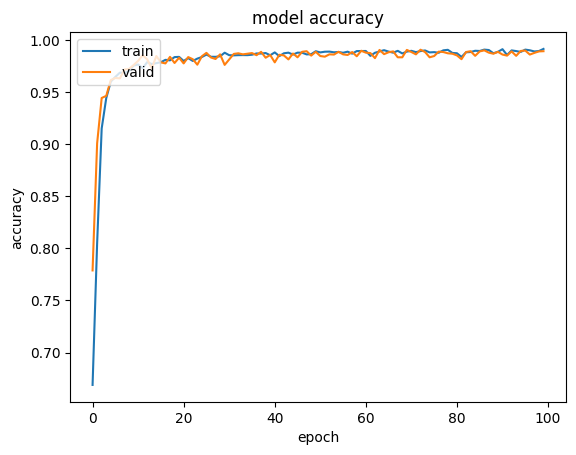

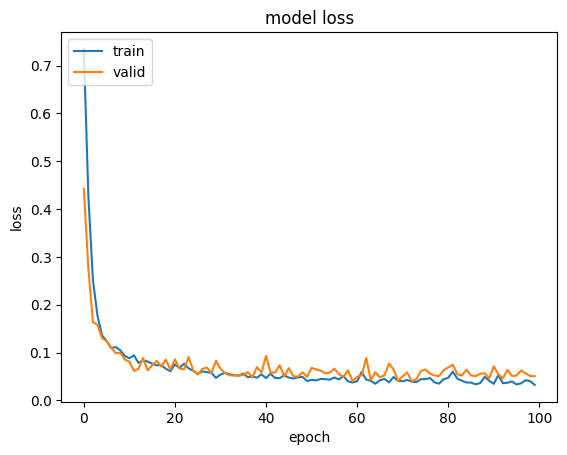

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [13]:
feature_test_set = np.load('/content/gdrive/MyDrive/DATN/Test_100_True_AIS_150_29.npz')
x_test = feature_test_set['x_test']
y_test = feature_test_set['y_test']

In [14]:
feature_test_set['x_test'].shape

(2818, 100, 39)

In [15]:
feature_test_set['y_test'].shape

(2818, 6)

In [16]:
print(f"Evaluating the model using {len(x_test)} samples...")
loss, accuracy = best_model.evaluate(x_test,y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 2818 samples...
Loss: 0.1608
Accuracy: 97.30%


In [17]:
#1_Wikioi','2_Batdieuhoa','3_Tatdieuhoa','4_Tang1do','5_Tang2do',
#'6_Tang3do','7_Giam1do','8_Giam2do','9_Giam3do','16_Bat26do','23_Batchedotudong','24_Batchedolammat','25_Batchedolamkho']
pre_y_test = []
pre_test = best_model.predict(x_test, verbose=0)
for i in range(0,y_test.shape[0]):
  # s=0
  # for j in pre_test[i]:
  #   if j > 5.0e-1:
  #     break
  #   s=s+1
  s = np.argmax(pre_test[i])
  match s:
    case 0:
      pre_y_test.append(["Batdieuhoa",y_test[i]])
    case 1:
      pre_y_test.append(["Tatdieuhoa",y_test[i]])
    case 2:
      pre_y_test.append(["Tang1do",y_test[i]])
    # case 3:
    #   pre_y_test.append(["Tang2do",data["y_valid"][i]])
    # case 4:
    #   pre_y_test.append(["Tang3do",data["y_valid"][i]])
    case 3:
      pre_y_test.append(["Giam1do",y_test[i]])
    # case 5:
    #   pre_y_test.append(["Giam2do",data["y_valid"][i]])
    # case 7:
    #   pre_y_test.append(["Giam3do",data["y_valid"][i]])
    case 4:
      pre_y_test.append(["Bat26do",y_test[i]])
    case 5:
      pre_y_test.append(["Noise",y_test[i]])
value_test=pd.DataFrame(pre_y_test,columns=['predict_label','reference_label'])
value_test

,predict_label,reference_label
0,Batdieuhoa,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,Batdieuhoa,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,Batdieuhoa,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,Batdieuhoa,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,Batdieuhoa,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...
2813,Noise,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2814,Noise,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2815,Noise,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2816,Noise,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [18]:
# testy = value_test['reference_label'].tolist()
ypredict = value_test['predict_label'].tolist()

In [19]:
# # Các tên nhãn
# label_names = ['Batdieuhoa','Tatdieuhoa','Tang1do','Tang2do','Tang3do','Giam1do','Giam2do','Giam3do','Bat26do','Noise']
label_names = ['Batdieuhoa','Tatdieuhoa','Tang1do','Giam1do','Bat26do','Noise']

# Tạo từ điển ánh xạ giữa index và tên nhãn
index_to_label = {i: label for i, label in enumerate(label_names)}

# Chuyển về dạng nhãn tương ứng
original_labels = [index_to_label[np.argmax(one_hot_array)] for one_hot_array in value_test['reference_label'].tolist()]

In [20]:
value_test['predict_label']

0       Batdieuhoa
1       Batdieuhoa
2       Batdieuhoa
3       Batdieuhoa
4       Batdieuhoa
           ...    
2813         Noise
2814         Noise
2815         Noise
2816         Noise
2817         Noise
Name: predict_label, Length: 2818, dtype: object

In [21]:
testy = original_labels

In [22]:
testy = original_labels
ypredict = value_test['predict_label'].tolist()

In [23]:
# ['BDH','TDH','T1D','G1D','B26D','Noise']

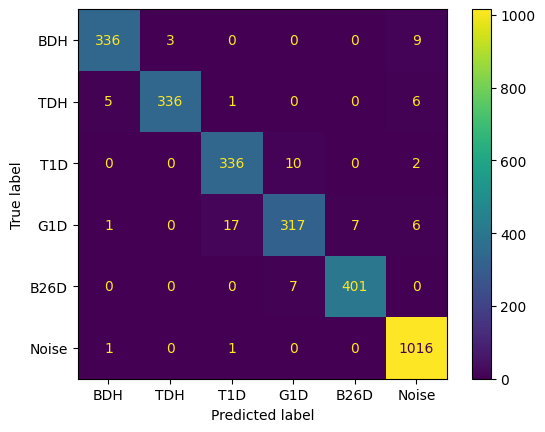

In [24]:
# 'Wikioi','Batdieuhoa','Tatdieuhoa','Tang1do','Tang2do','Tang3do','Giam1do','Giam2do','Giam3do','Bat26do','Batchedotudong','Batchedolammat','Batchedolamkho'
conf_matrix = confusion_matrix(testy, ypredict, labels = ['Batdieuhoa','Tatdieuhoa','Tang1do','Giam1do','Bat26do','Noise'])
disp = ConfusionMatrixDisplay( confusion_matrix=conf_matrix, display_labels=['BDH','TDH','T1D','G1D','B26D','Noise'])
disp.plot()
plt.show()